In [1]:
import requests
import json
import glob
import datetime
from io import StringIO
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('ticks')

In [2]:
# ids (states) for sensor URL parameters
states = 'AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME \
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT \
 WA WI WV WY'.split()

In [3]:
# create network ids from list of state ids
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

In [4]:
def get_weather(stations, start=pd.Timestamp('2014-01-01'), end=pd.Timestamp('2014-01-31')):
    '''
        fetch weather from MESOnet between start and end dates
    '''
    
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")

    stations = '&'.join('station={}'.format(s) for s in stations)

    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                           comment='#')
                 .rename(columns={'valid': 'date'})
                 .rename(columns=str.strip)
                 .assign(date=lambda df: pd.to_datetime(df['date']))
                 .set_index(['station', 'date'])
                 .sort_index())
    
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="coerce")
    
    return weather

In [5]:
def get_ids(network):
    '''
        get sensor id from network
    '''
    
    url = 'http://mesonet.agron.iastate.edu/geojson/network.php?network={}'
    
    r = requests.get(url.format(network))
    
    md = json_normalize(r.json()['features'])
    
    md['network'] = network
    
    return md

In [6]:
# get sensor ids
ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)

In [7]:
# group ids by network
id_groups = ids.groupby('network')

In [8]:
# create csv files for weather data
import os

os.makedirs("weather", exist_ok=True)

for i, (k, v) in enumerate(id_groups):
    print("{}/{}".format(i, len(networks)), end='\r')
    weather = get_weather(v['id'])
    weather.to_csv("weather/{}.csv".format(k))

/home/gr4vy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/home/gr4vy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [22]:
weather = pd.concat([
    pd.read_csv(f, parse_dates=['date'], index_col=['station', 'date'])
    for f in glob.glob('weather/*.csv')])

weather.to_hdf("weather.h5", "weather")

In [23]:
weather = pd.read_hdf('weather.h5', 'weather').sort_index()

In [24]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                  
01M     2014-01-01 00:15:00  33.80  85.86   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:35:00  33.44  87.11   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:55:00  32.54  90.97   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:15:00  31.82  93.65   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:35:00  32.00  92.97   0.0   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
01M     2014-01-01 00:15:00   CLR     M     M  
        2014-01-01 00:35:00   CLR     M     M  
        2014-01-01 00:55:00   CLR     M     M  
        2014-01-01 01:15:00   CLR     M     M  
        2014-01-01 01:35:00   CLR     M     M

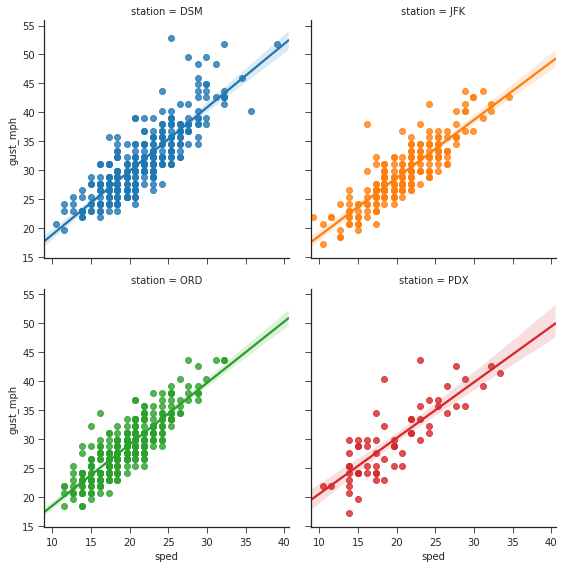

In [25]:
airports = ['DSM', 'ORD', 'JFK', 'PDX']

g =  sns.FacetGrid(weather.sort_index().loc[airports].reset_index(),
                       col='station', hue='station', col_wrap=2, size=4)

g.map(sns.regplot, 'sped', 'gust_mph')

In [28]:
# find the set of airports that we have weather and flight information
flights = pd.read_hdf('flights.h5', 'flights')

weather_locs = weather.index.levels[0]

origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

airports = weather_locs & origin_locs & dest_locs

airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'AEX', 'AGS', 'ALB',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=267)

In [29]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1909)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BKG', 'BQN', 'BRW', 'CDV', 'CLD', 'FAI',
       'FCA', 'GUM', 'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG',
       'OME', 'OTZ', 'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT',
       'STX', 'WRG', 'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1943)
